## Credit Card Fraud Detection
- Checking for null values
- Dropping useless columns
- Checking balance of dataset

In [1]:
# Importing libraries
import optuna
import xgboost
import hyperopt
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from scipy.stats import ttest_ind
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from bayes_opt import BayesianOptimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, atpe

C:\Users\zipin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\zipin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\zipin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

In [120]:
# Reading Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Looking for null values
print("Number of null values: ", train.isna().sum().sum())
train.head()

Number of null values:  0


,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,2.046081,0.063139,-1.819306,0.225942,0.616907,-0.307267,0.031888,-0.020023,0.317273,...,-0.332434,-0.898589,0.302205,0.114724,-0.276467,0.179722,-0.066318,-0.045333,0.89,0
1,1,0.190460,1.398417,-3.257814,-0.438898,3.558473,3.304793,-0.558896,-2.002610,-1.180829,...,-1.344980,0.206201,-0.381615,0.539618,1.253612,0.996955,0.059223,0.278219,0.76,0
2,2,-1.056273,0.011954,1.042614,-3.232065,-0.859991,-0.537365,-0.141665,0.451848,-2.817590,...,-0.547078,-1.532374,0.051689,-0.462780,0.303062,-0.637594,0.115927,0.034376,57.60,0
3,3,-0.391543,-3.788951,-2.589369,-0.913835,0.728928,3.512187,0.435274,0.449908,-1.009831,...,0.684785,-0.323202,-1.054609,1.106205,0.593745,-0.153336,-0.189821,0.165970,979.86,0
4,4,-0.116071,0.397537,1.713937,-0.922230,-0.587344,-0.771956,0.176400,-0.212483,-1.688544,...,0.039585,0.065823,0.027460,0.419605,-0.494686,-0.462999,0.157592,0.151344,15.00,0


In [121]:
# Finding Useless Columns
train = train.drop(columns = 'Unnamed: 0')
col_names = train.columns

print("Dimension of data: ", train.shape)
train.head()

Dimension of data:  (40000, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2.046081,0.063139,-1.819306,0.225942,0.616907,-0.307267,0.031888,-0.020023,0.317273,-0.204635,...,-0.332434,-0.898589,0.302205,0.114724,-0.276467,0.179722,-0.066318,-0.045333,0.89,0
1,0.190460,1.398417,-3.257814,-0.438898,3.558473,3.304793,-0.558896,-2.002610,-1.180829,-1.927118,...,-1.344980,0.206201,-0.381615,0.539618,1.253612,0.996955,0.059223,0.278219,0.76,0
2,-1.056273,0.011954,1.042614,-3.232065,-0.859991,-0.537365,-0.141665,0.451848,-2.817590,0.538246,...,-0.547078,-1.532374,0.051689,-0.462780,0.303062,-0.637594,0.115927,0.034376,57.60,0
3,-0.391543,-3.788951,-2.589369,-0.913835,0.728928,3.512187,0.435274,0.449908,-1.009831,0.190006,...,0.684785,-0.323202,-1.054609,1.106205,0.593745,-0.153336,-0.189821,0.165970,979.86,0
4,-0.116071,0.397537,1.713937,-0.922230,-0.587344,-0.771956,0.176400,-0.212483,-1.688544,0.288885,...,0.039585,0.065823,0.027460,0.419605,-0.494686,-0.462999,0.157592,0.151344,15.00,0


0    39629
1      371
Name: Class, dtype: int64

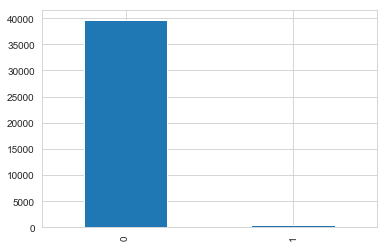

In [122]:
# Labelling the training data
x_train = train.drop(columns="Class")
y_train = train[["Class"]]

# Checking balance of training data
pd.Series(y_train["Class"]).value_counts().plot.bar()
x_train, y_train = shuffle(x_train, y_train)
y_train["Class"].value_counts()

## Pre-Processing of Data
- Stratified Kfold
- Baseline (pipeline)
    - MinMax
    - Robust
    - Normalization
    - Standardisation
- Removing Outliers (Did not do due to PCA already done)
- Over-Sampling (Did not do due to decrease of accuracy)
    - SMOTE
- Under-Sampling (Did not do due to decrease of accuracy)
    - Random

In [105]:
# Defining Stratified Kfold Cross-Validation
cv_acc = {}
def kfold(model, X, y):
    i = 1
    cv_score =[]
    pred_test_full =0
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    
    for train_index, test_index in kf.split(X,y):
        print('{} of KFold {}'.format(i,kf.n_splits))
        xtr, xvl = X.iloc[train_index],X.iloc[test_index]
        ytr, yvl = y.iloc[train_index],y.iloc[test_index]
    
        model.fit(xtr,ytr["Class"].values.ravel())
        score = f1_score(yvl["Class"].values.ravel(), model.predict(xvl))
        print('F1 Score: ',score)
        cv_score.append(score)    
        i+=1
    
    print('\nMean F1 Score:', np.mean(cv_score))
    return np.mean(cv_score)

<Figure size 432x288 with 0 Axes>

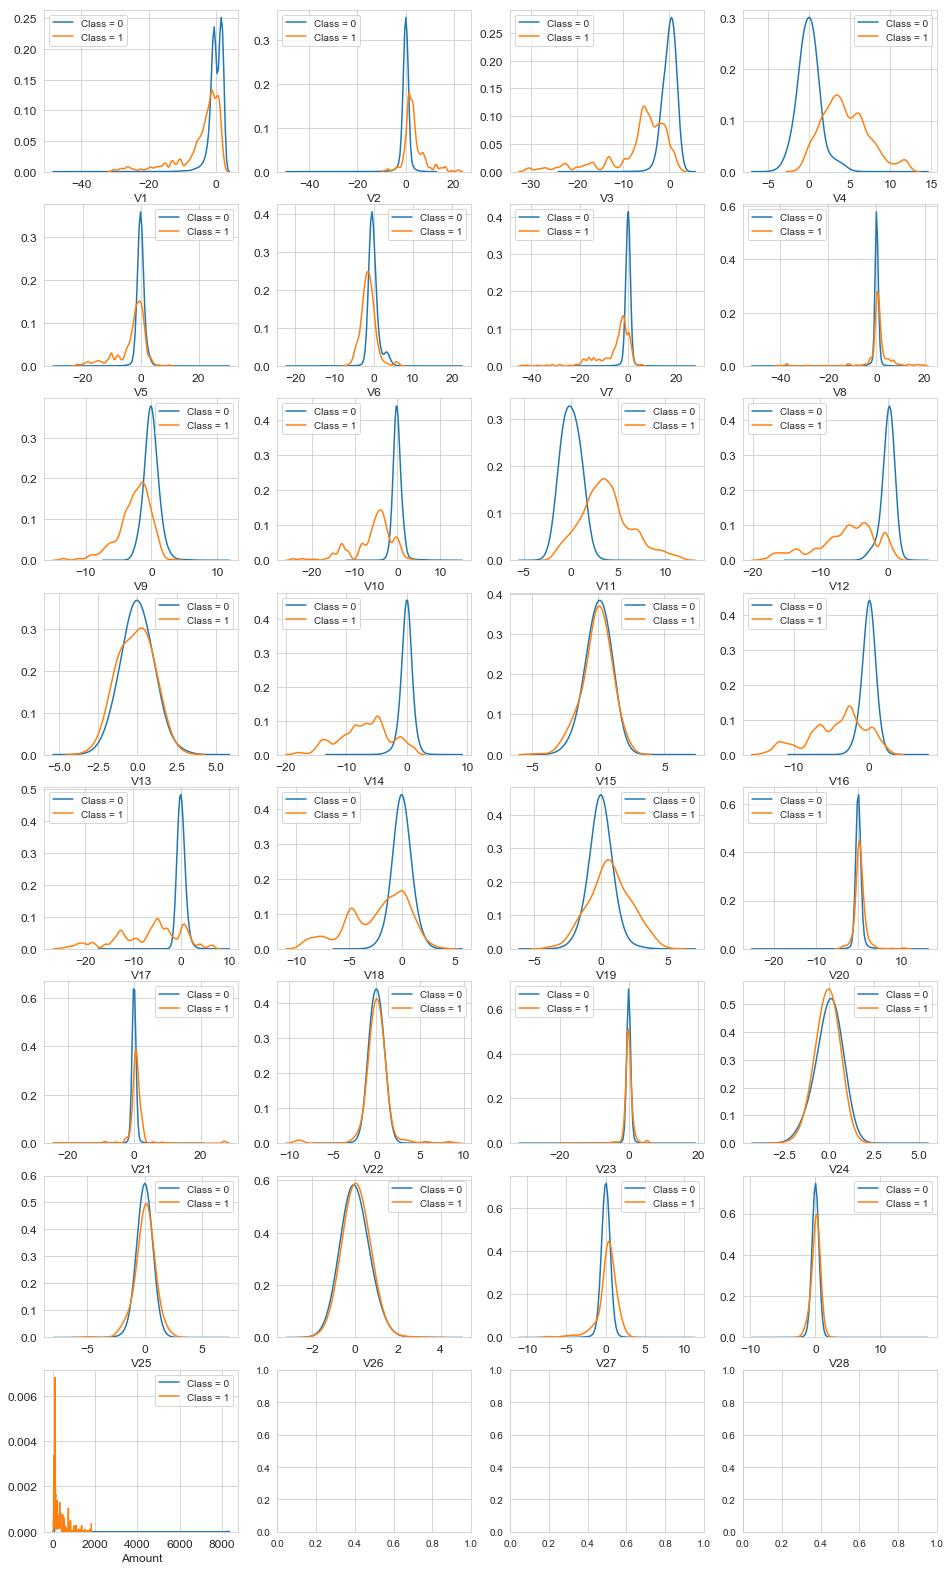

In [6]:
# Checking for normality of features
import matplotlib.pyplot as plt
import seaborn as sns
var = x_train.columns.values

i = 0
t0 = x_train.loc[y_train['Class'] == 0]
t1 = x_train.loc[y_train['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5, label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5, label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [ ]:
# Checking for Outliers (Did not do)
x_train = x_train.reset_index()
y_train = y_train.reset_index()

columns = ["V13", "V15", "V24"]
norm_features = col_names[:-1]
to_be_removed = []

for i in columns:
    elements = np.array(x_train[i])
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    feature = []
    for j in range(len(elements)):
        if (elements[j] < mean - 3 * sd) or (elements[j] > mean + 3 * sd):
            feature.append(j)
    to_be_removed.append(feature)

In [ ]:
# Removing Outliers (Did not do)
combined = []
for i in to_be_removed:
    combined += i
combined = set(combined)
x_train = x_train.drop(combined)
y_train = y_train.drop(combined)

# Dropping Index
x_train = x_train.drop(columns = ["index"])
y_train = y_train.drop(columns = ["index"])

# Checking balance of training data
y_train["Class"].value_counts()

In [ ]:
# Over-Sampling default data (Did not do)
smote = SMOTE(sampling_strategy = 'minority', random_state=0)
x_train, y_train = smote.fit_sample(x_train, y_train["Class"].values.ravel())

x_train, y_train = shuffle(x_train, y_train)
x_train = pd.DataFrame(x_train, columns = col_names[:-1])
y_train = pd.DataFrame(y_train, columns = ["Class"])

# Checking the balance of data
pd.Series(y_train["Class"]).value_counts().plot.bar()
print(y_train["Class"].value_counts())

In [ ]:
# Random Under-Sampling (Did not do)
ros = RandomUnderSampler(random_state=0)
x_train, y_train = ros.fit_resample(x_train, y_train)

x_train = pd.DataFrame(x_train, columns = col_names[:-1])
y_train = pd.DataFrame(y_train, columns = ["Class"])

# Checking the balance of data
pd.Series(y_train["Class"]).value_counts().plot.bar()
print(y_train["Class"].value_counts())

In [7]:
# Instantiate the pre-processors
normalize = Normalizer()
minmax = MinMaxScaler()
standardize = StandardScaler()
robust = RobustScaler(quantile_range=(25, 75))

preprocessor = {}
preprocessor["Normalize"] = normalize
preprocessor["Min Max"] = minmax
preprocessor["Standardize"] = standardize
preprocessor["Robust"] = robust
preprocessor["None"] = None

In [8]:
# Running baseline accuracy for model selection
pre_dict = {}
models = {'K-Nearest Neighbours':KNeighborsClassifier(), 
          'XGBoost':XGBClassifier(random_state = 0), 
          'Light GMBoost':LGBMClassifier(random_state = 0), 
          'Neural Network':MLPClassifier(random_state = 0), 
          'Logistic Regression':LogisticRegression(random_state = 0), 
          'Support Vector Machine':SVC(random_state = 0), 
          'Random Forest':RandomForestClassifier(random_state = 0)}

for i in models:
    for j in preprocessor:
        pipeline = make_pipeline(preprocessor[j], models[i])
        score = kfold(pipeline, x_train, y_train)
        pre_dict[(i,j)] = score

1 of KFold 5
F1 Score:  0.8840579710144927
2 of KFold 5
F1 Score:  0.8428571428571429
3 of KFold 5
F1 Score:  0.9142857142857143
4 of KFold 5
F1 Score:  0.7226890756302521
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8545961625757021
1 of KFold 5
F1 Score:  0.8905109489051095
2 of KFold 5
F1 Score:  0.8633093525179857
3 of KFold 5
F1 Score:  0.920863309352518
4 of KFold 5
F1 Score:  0.8031496062992127
5 of KFold 5
F1 Score:  0.9166666666666666

Mean F1 Score: 0.8788999767482986
1 of KFold 5
F1 Score:  0.874074074074074
2 of KFold 5
F1 Score:  0.8550724637681159
3 of KFold 5
F1 Score:  0.8985507246376812
4 of KFold 5
F1 Score:  0.7540983606557377
5 of KFold 5
F1 Score:  0.915492957746479

Mean F1 Score: 0.8594577161764174
1 of KFold 5
F1 Score:  0.8396946564885496
2 of KFold 5
F1 Score:  0.835820895522388
3 of KFold 5
F1 Score:  0.874074074074074
4 of KFold 5
F1 Score:  0.711864406779661
5 of KFold 5
F1 Score:  0.9078014184397163

Mean F1 Score: 0.8338510902608778
1 of K

C:\Users\zipin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1 Score:  0.8633093525179857
2 of KFold 5


C:\Users\zipin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1 Score:  0.8467153284671532
3 of KFold 5


C:\Users\zipin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1 Score:  0.9142857142857143
4 of KFold 5


C:\Users\zipin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1 Score:  0.8095238095238095
5 of KFold 5


C:\Users\zipin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1 Score:  0.8794326241134751

Mean F1 Score: 0.8626533657816277
1 of KFold 5
F1 Score:  0.8095238095238095
2 of KFold 5
F1 Score:  0.7812500000000001
3 of KFold 5
F1 Score:  0.8095238095238095
4 of KFold 5
F1 Score:  0.7226890756302521
5 of KFold 5
F1 Score:  0.8153846153846154

Mean F1 Score: 0.7876742620124974
1 of KFold 5
F1 Score:  0.8905109489051095
2 of KFold 5
F1 Score:  0.8633093525179857
3 of KFold 5
F1 Score:  0.920863309352518
4 of KFold 5
F1 Score:  0.7936507936507937
5 of KFold 5
F1 Score:  0.9230769230769231

Mean F1 Score: 0.878282265500666
1 of KFold 5
F1 Score:  0.8307692307692307
2 of KFold 5
F1 Score:  0.7906976744186047
3 of KFold 5
F1 Score:  0.8872180451127819
4 of KFold 5
F1 Score:  0.711864406779661
5 of KFold 5
F1 Score:  0.8823529411764706

Mean F1 Score: 0.8205804596513498
1 of KFold 5
F1 Score:  0.8217054263565892
2 of KFold 5
F1 Score:  0.7968749999999999
3 of KFold 5
F1 Score:  0.8437499999999999
4 of KFold 5
F1 Score:  0.7008547008547009
5 of KFold 5
F1 

In [9]:
# Table for training accuracy of different pre-processors and models
pre_dict = {k: v for k, v in sorted(pre_dict.items(), key=lambda item: item[1], reverse=True)}
data = pd.DataFrame({'Pre-Processor, Model':list(pre_dict.keys()), 'Training Scores':list(pre_dict.values())})
data

,"Pre-Processor, Model",Training Scores
0,"(Random Forest, Min Max)",0.897316
1,"(Random Forest, Standardize)",0.897316
2,"(Random Forest, Robust)",0.897316
3,"(Random Forest, None)",0.897316
4,"(Neural Network, Robust)",0.888703
5,"(XGBoost, Standardize)",0.887962
6,"(XGBoost, Robust)",0.887962
7,"(XGBoost, None)",0.887962
8,"(Light GMBoost, Min Max)",0.887046
9,"(XGBoost, Min Max)",0.886177


## Feature Importance
- Correlation Matrix
- T-Test Statistic

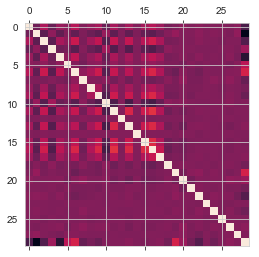

None


In [10]:
# Checking for correlation between features
import matplotlib.pyplot as plt
plt.matshow(x_train.corr())
print(plt.show())

In [11]:
# Feature importance using T test
from scipy.stats import ttest_ind
t_stats = []
for i in col_names[:-1]:
    t, p = ttest_ind(train[[i]], train[["Class"]], equal_var=False)
    t_stats.append((i, abs(t)))
    print(i + " [t = %g,  p = %g]" % (t, p))

V1 [t = -4.965,  p = 6.89837e-07]
V2 [t = 1.26624,  p = 0.205436]
V3 [t = -7.36056,  p = 1.86637e-13]
V4 [t = 4.30328,  p = 1.68681e-05]
V5 [t = -2.20285,  p = 0.0276106]
V6 [t = -2.19225,  p = 0.0283674]
V7 [t = -7.97291,  p = 1.59031e-15]
V8 [t = -0.651887,  p = 0.514478]
V9 [t = -3.09115,  p = 0.00199515]
V10 [t = -8.29535,  p = 1.11571e-16]
V11 [t = 3.07931,  p = 0.0020762]
V12 [t = -8.0773,  p = 6.80312e-16]
V13 [t = -3.90191,  p = 9.55907e-05]
V14 [t = -11.1214,  p = 1.08646e-28]
V15 [t = -2.07686,  p = 0.0378209]
V16 [t = -9.20037,  p = 3.73127e-20]
V17 [t = -9.85165,  p = 7.1539e-23]
V18 [t = -5.80969,  p = 6.30507e-09]
V19 [t = -0.000375108,  p = 0.999701]
V20 [t = -1.32077,  p = 0.186585]
V21 [t = -2.42826,  p = 0.0151756]
V22 [t = -2.56555,  p = 0.0103049]
V23 [t = -2.79807,  p = 0.00514328]
V24 [t = -2.68037,  p = 0.00735694]
V25 [t = -4.59563,  p = 4.32672e-06]
V26 [t = -2.78332,  p = 0.00538297]
V27 [t = -2.31068,  p = 0.0208553]
V28 [t = -5.31771,  p = 1.05553e-07]
Amoun

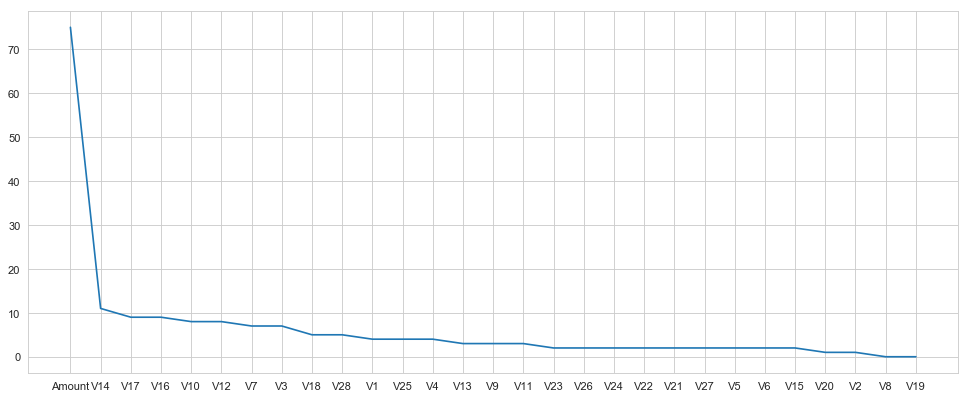

In [12]:
# PLotting T-Statistic
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

list.sort(t_stats, key= lambda x : x[1], reverse = True)
x_axis = []
y_axis = []

for i, j in t_stats:
    x_axis.append(i)
    y_axis.append(int(j))
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x_axis, y_axis)

## Comparing Hyper-parameter Tuning Algorithms
- Randomised/ Grid Search
- Bayesian Optimisation (HyperOpt)
    - Tree of Parzen Algorithm (TPE)
    - Adaptive Tree of Parzen Algorithm (ATPE)
- Bayesian Optimisation (Optuna)
- Bayesian Optimisation (BayesianOptimisation)

## Randomised/ Grid Search
- Takes much longer than the rest
- Not the best in accuracy due to manual assignment of parameters

In [22]:
# Randomised Search
grid = {'n_estimators':range(0, 400, 50),
        'max_depth':range(1,10,2), 
        'min_child_weight':range(1,6,2),
        'gamma':[i/10.0 for i in range(0,10)],
        'subsample':[i/10.0 for i in range(6,10)], 
        'colsample_bytree':[i/10.0 for i in range(6,11)],
        'class_weight':['balanced', 'none']}

xgb = XGBClassifier(random_state = 0)
xgb = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_iter=100, scoring = 'f1',
                        cv=3, refit=True, random_state=0, verbose=True, n_jobs=-1)
xgb.fit(x_train, y_train["Class"].values)

print("Best Parameters: ", xgb.best_params_)
print("Accuracy :", xgb.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.9min finished


Best Parameters:  {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 0.4, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}
Accuracy : 0.8972054365830185


In [35]:
# Grid Search with the optimised parameters
grid = {'n_estimators':range(80, 120, 10),
        'max_depth':range(3,7,1),
        'min_child_weight':range(1,3,1),
        'gamma':[i/10.0 for i in range(3,5)],
        'subsample':[i/10.0 for i in range(8,10)], 
        'colsample_bytree':[i/10.0 for i in range(7,9)]}

xgb = XGBClassifier(random_state = 0)
xgb = GridSearchCV(estimator=xgb, param_grid=grid, scoring = 'f1',
                        cv=3, refit=True, verbose=True, n_jobs=-1)
xgb.fit(x_train, y_train["Class"].values)

print("Best Parameters: ", xgb.best_params_)
print("Accuracy :", xgb.best_score_)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 18.5min finished


Best Parameters:  {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 110, 'subsample': 0.9}
Accuracy : 0.9016829216817647


In [ ]:
# Accuracy for baseline model
xgb = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=8, random_state = 0,
                    min_child_weight=1, gamma=0.4, subsample=0.9, colsample_bytree=0.8,
                    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

xgb_score = kfold(xgb, x_train, y_train)
cv_acc["Random/Grid"] = xgb_score

## Bayes Optimisation (HyperOpt)
- Tree of Parzen Estimator
- Adaptive Tree of Parzen Estimator
- Best all rounded, not 2nd fastest and can handle choices

In [27]:
# Defining parameter grid
space = {'n_estimators': hp.quniform('n_estimators', 50, 400, 50),
        'max_depth': hp.quniform('max_depth', 1, 11, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'gamma': hp.uniform('gamma', 0.1, 0.5),
        'subsample': hp.uniform('subsample', 0.6, 0.9), 
        'colsample_bytree':hp.uniform('colsample_bytree', 0.6, 0.9),
        'class_weight': hp.choice('class_weight', ['balanced', 'none'])}

In [28]:
# Defining Objective Function
def hyperparameter_tuning(space):
    clf=XGBClassifier(n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'], 
                          min_child_weight=int(space['min_child_weight']), colsample_bytree=space['colsample_bytree'],
                          subsample=space['subsample'], class_weight=['class_weight'], random_state = 0)
    
    accuracy = kfold(clf, x_train, y_train)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [29]:
# Running trials (TPE)
trials = Trials()
best = fmin(fn=hyperparameter_tuning, space=space, algo=tpe.suggest,
            max_evals=20, trials=trials)
print(best)

1 of KFold 5                                        
F1 Score:                                           
0.8985507246376812                                  
2 of KFold 5                                        
F1 Score:                                           
0.8794326241134752                                  
3 of KFold 5                                        
F1 Score:                                           
0.9428571428571428                                  
4 of KFold 5                                        
F1 Score:                                           
0.8307692307692307                                  
5 of KFold 5                                        
F1 Score:                                           
0.9142857142857143                                  
                                                    
Mean F1 Score:
0.8931790873326488                                  
1 of KFold 5                                                                  
F1 Sc

3 of KFold 5                                                                   
F1 Score:                                                                      
0.9361702127659575                                                             
4 of KFold 5                                                                   
F1 Score:                                                                      
0.8396946564885496                                                             
5 of KFold 5                                                                   
F1 Score:                                                                      
0.9219858156028369                                                             
                                                                               
Mean F1 Score:
0.8960918761019036                                                             
1 of KFold 5                                                                   
F1 Score:                

In [106]:
# Accuracy of tuned model
xgb = XGBClassifier(learning_rate =0.1, n_estimators=300, max_depth=8, random_state = 0,
                    min_child_weight=2, gamma=0.3487141998119373, subsample=0.6619778224023228, colsample_bytree=0.8452886181642807,
                    objective= 'binary:logistic', nthread=4)

xgb_score = kfold(xgb, x_train, y_train)
cv_acc["HyperOpt (TPE)"] = xgb_score

1 of KFold 5
F1 Score:  0.9361702127659575
2 of KFold 5
F1 Score:  0.927536231884058
3 of KFold 5
F1 Score:  0.8550724637681159
4 of KFold 5
F1 Score:  0.8955223880597014
5 of KFold 5
F1 Score:  0.8571428571428571

Mean F1 Score: 0.8942888307241379


In [16]:
# Running trials(ATPE)
trials = Trials()

best = fmin(fn=hyperparameter_tuning, space=space, algo=atpe.suggest,
            max_evals=20, trials=trials)
print(best)

1 of KFold 5                                        
F1 Score:                                           
0.8905109489051095                                  
2 of KFold 5                                        
F1 Score:                                           
0.8794326241134752                                  
3 of KFold 5                                        
F1 Score:                                           
0.9361702127659575                                  
4 of KFold 5                                        
F1 Score:                                           
0.8217054263565892                                  
5 of KFold 5                                        
F1 Score:                                           
0.9078014184397163                                  
                                                    
Mean F1 Score:
0.8871241261161696                                  
1 of KFold 5                                                                  
F1 Sc

3 of KFold 5                                                                   
F1 Score:                                                                      
0.935251798561151                                                              
4 of KFold 5                                                                   
F1 Score:                                                                      
0.8461538461538461                                                             
5 of KFold 5                                                                   
F1 Score:                                                                      
0.9078014184397163                                                             
                                                                               
Mean F1 Score:
0.8930911259038027                                                             
1 of KFold 5                                                                   
F1 Score:                

In [107]:
# Accuracy of tuned model
xgb = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=11, random_state = 0,
                    min_child_weight=1, gamma=0.2878935877431736, subsample=0.830135709475659, colsample_bytree=0.8703800035831872,
                    objective= 'binary:logistic', nthread=4, class_weight = 'balanced')

xgb_score = kfold(xgb, x_train, y_train)
cv_acc["HyperOpt (ATPE)"] = xgb_score

1 of KFold 5
F1 Score:  0.950354609929078
2 of KFold 5
F1 Score:  0.935251798561151
3 of KFold 5
F1 Score:  0.8592592592592593
4 of KFold 5
F1 Score:  0.8955223880597014
5 of KFold 5
F1 Score:  0.8571428571428571

Mean F1 Score: 0.8995061825904094


## Bayesian Optimisation (Bayesian-Optimisation)
- Fastest compared to the rest
- Cannot handle choices/ categories but only numbers

In [17]:
# Defining parameter grid
space = {'n_estimators':(0,400),
        'max_depth':(1,10), 
        'min_child_weight':(1,5),
        'gamma':(0.0,1.0),
        'subsample':(0.6, 1.0), 
        'colsample_bytree':(0.6, 1.0)}

In [18]:
# Defining Objective Function
def hyperparameter_tuning(n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree):
    clf=XGBClassifier(n_estimators = int(n_estimators), max_depth = int(max_depth), gamma = gamma, 
                          min_child_weight=int(min_child_weight), colsample_bytree=colsample_bytree,
                          subsample=subsample, random_state = 0)

    accuracy = kfold(clf, x_train, y_train)
    print ("SCORE:", accuracy)
    return accuracy

In [19]:
# Defining optimiser and running trials
optimizer = BayesianOptimization(f=hyperparameter_tuning, pbounds=space,
                                 verbose=2, random_state=1)

optimizer.maximize(init_points=10, n_iter=10,)
print(optimizer.max)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
1 of KFold 5
F1 Score:  0.8636363636363636
2 of KFold 5
F1 Score:  0.8467153284671532
3 of KFold 5
F1 Score:  0.888888888888889
4 of KFold 5
F1 Score:  0.8
5 of KFold 5
F1 Score:  0.9027777777777778

Mean F1 Score: 0.8604036717540368
SCORE: 0.8604036717540368
|  1        |  0.8604   |  0.7668   |  0.7203   |  1.001    |  2.209    |  58.7     |  0.6369   |
1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8776978417266187
3 of KFold 5
F1 Score:  0.935251798561151
4 of KFold 5
F1 Score:  0.8307692307692307
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8902721009571181
SCORE: 0.8902721009571181
|  2        |  0.8903   |  0.6745   |  0.3456   |  4.571    |  3.155    |  167.7    |  0.8741   |
1 of KFold 5
F1 Score:  0.8905109489051095
2 of KFold 5
F1 Score:  0.8550

In [108]:
# Accuracy of tuned model
xgb = XGBClassifier(learning_rate =0.1, n_estimators=235, max_depth=6,
                    min_child_weight=1, gamma=0.053362545117080384, subsample=0.8799033440083724, 
                    colsample_bytree=0.7966292637121353, random_state = 0,
                    objective= 'binary:logistic', nthread=4)

xgb_score = kfold(xgb, x_train, y_train)
cv_acc["Bayes-Optimization"] = xgb_score

1 of KFold 5
F1 Score:  0.9428571428571428
2 of KFold 5
F1 Score:  0.927536231884058
3 of KFold 5
F1 Score:  0.8444444444444444
4 of KFold 5
F1 Score:  0.8955223880597014
5 of KFold 5
F1 Score:  0.8652482269503545

Mean F1 Score: 0.8951216868391402


## Bayesian Optimisation (Optuna)
- Cannot handle many decimal places hence not as precise

In [20]:
# Defining objective function
def objective(trial):
    n_estimator = trial.suggest_int('n_estimator', 0, 400)
    max_depth = trial.suggest_int('max_depth', 1, 9)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    gamma = trial.suggest_discrete_uniform('gamma', 0, 1, 0.1)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'none'])
    
    regressor_obj = xgboost.sklearn.XGBClassifier(n_estimator = n_estimator, max_depth = max_depth, random_state = 0,
                                                  min_child_weight = min_child_weight, class_weight = class_weight,
                                                  gamma = gamma, colsample_bytree=colsample_bytree, subsample=subsample)

    accuracy = kfold(regressor_obj, x_train, y_train)
    print ("SCORE:", accuracy)
    return accuracy

In [21]:
# Creating Study for trials
study = optuna.create_study()
study.optimize(objective, n_trials=20)
study.trials_dataframe().sort_values('value', ascending = False)

1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8794326241134752
3 of KFold 5
F1 Score:  0.9285714285714285
4 of KFold 5
F1 Score:  0.8244274809160306
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8880146334659049
SCORE: 0.8880146334659049


[I 2020-01-10 10:37:34,872] Finished trial#0 resulted in value: 0.8880146334659049. Current best value is 0.8880146334659049 with parameters: {'n_estimator': 32, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.0, 'subsample': 0.8, 'colsample_bytree': 0.7, 'class_weight': 'balanced'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.921985815602837
4 of KFold 5
F1 Score:  0.8125
5 of KFold 5
F1 Score:  0.9027777777777778

Mean F1 Score: 0.8814485778893735
SCORE: 0.8814485778893735


[I 2020-01-10 10:37:50,653] Finished trial#1 resulted in value: 0.8814485778893735. Current best value is 0.8814485778893735 with parameters: {'n_estimator': 131, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.7000000000000001, 'subsample': 0.5, 'colsample_bytree': 0.5, 'class_weight': 'balanced'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8633093525179857
3 of KFold 5
F1 Score:  0.921985815602837
4 of KFold 5
F1 Score:  0.806201550387597
5 of KFold 5
F1 Score:  0.9027777777777778

Mean F1 Score: 0.8785650441847757
SCORE: 0.8785650441847757


[I 2020-01-10 10:38:00,406] Finished trial#2 resulted in value: 0.8785650441847757. Current best value is 0.8785650441847757 with parameters: {'n_estimator': 278, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8920863309352518
2 of KFold 5
F1 Score:  0.8794326241134752
3 of KFold 5
F1 Score:  0.920863309352518
4 of KFold 5
F1 Score:  0.8244274809160306
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8851801308816369
SCORE: 0.8851801308816369


[I 2020-01-10 10:38:30,989] Finished trial#3 resulted in value: 0.8851801308816369. Current best value is 0.8785650441847757 with parameters: {'n_estimator': 278, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8550724637681159
3 of KFold 5
F1 Score:  0.920863309352518
4 of KFold 5
F1 Score:  0.8244274809160306
5 of KFold 5
F1 Score:  0.9078014184397163

Mean F1 Score: 0.8813430794228123
SCORE: 0.8813430794228123


[I 2020-01-10 10:38:54,063] Finished trial#4 resulted in value: 0.8813430794228123. Current best value is 0.8785650441847757 with parameters: {'n_estimator': 278, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.920863309352518
4 of KFold 5
F1 Score:  0.8307692307692307
5 of KFold 5
F1 Score:  0.9078014184397163

Mean F1 Score: 0.8858826509255436
SCORE: 0.8858826509255436


[I 2020-01-10 10:39:34,023] Finished trial#5 resulted in value: 0.8858826509255436. Current best value is 0.8785650441847757 with parameters: {'n_estimator': 278, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.920863309352518
4 of KFold 5
F1 Score:  0.8217054263565892
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8843277881732539
SCORE: 0.8843277881732539


[I 2020-01-10 10:39:48,029] Finished trial#6 resulted in value: 0.8843277881732539. Current best value is 0.8785650441847757 with parameters: {'n_estimator': 278, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8794326241134752
3 of KFold 5
F1 Score:  0.9142857142857143
4 of KFold 5
F1 Score:  0.8244274809160306
5 of KFold 5
F1 Score:  0.9027777777777778

Mean F1 Score: 0.8838948643461357
SCORE: 0.8838948643461357


[I 2020-01-10 10:40:06,467] Finished trial#7 resulted in value: 0.8838948643461357. Current best value is 0.8785650441847757 with parameters: {'n_estimator': 278, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.9295774647887325
4 of KFold 5
F1 Score:  0.8125
5 of KFold 5
F1 Score:  0.9027777777777778

Mean F1 Score: 0.8829669077265526
SCORE: 0.8829669077265526


[I 2020-01-10 10:40:22,204] Finished trial#8 resulted in value: 0.8829669077265526. Current best value is 0.8785650441847757 with parameters: {'n_estimator': 278, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.9361702127659575
4 of KFold 5
F1 Score:  0.806201550387597
5 of KFold 5
F1 Score:  0.9027777777777778

Mean F1 Score: 0.883025767399517
SCORE: 0.883025767399517


[I 2020-01-10 10:40:32,490] Finished trial#9 resulted in value: 0.883025767399517. Current best value is 0.8785650441847757 with parameters: {'n_estimator': 278, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8905109489051095
2 of KFold 5
F1 Score:  0.8550724637681159
3 of KFold 5
F1 Score:  0.921985815602837
4 of KFold 5
F1 Score:  0.8031496062992127
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8759619487332369
SCORE: 0.8759619487332369


[I 2020-01-10 10:40:38,876] Finished trial#10 resulted in value: 0.8759619487332369. Current best value is 0.8759619487332369 with parameters: {'n_estimator': 393, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.5, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.888888888888889
2 of KFold 5
F1 Score:  0.8550724637681159
3 of KFold 5
F1 Score:  0.921985815602837
4 of KFold 5
F1 Score:  0.8031496062992127
5 of KFold 5
F1 Score:  0.9027777777777778

Mean F1 Score: 0.8743749104673665
SCORE: 0.8743749104673665


[I 2020-01-10 10:40:46,560] Finished trial#11 resulted in value: 0.8743749104673665. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.888888888888889
2 of KFold 5
F1 Score:  0.8550724637681159
3 of KFold 5
F1 Score:  0.9295774647887325
4 of KFold 5
F1 Score:  0.8031496062992127
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8771558665671719
SCORE: 0.8771558665671719


[I 2020-01-10 10:40:53,688] Finished trial#12 resulted in value: 0.8771558665671719. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8794326241134752
3 of KFold 5
F1 Score:  0.920863309352518
4 of KFold 5
F1 Score:  0.8153846153846154
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8846644365158397
SCORE: 0.8846644365158397


[I 2020-01-10 10:41:14,629] Finished trial#13 resulted in value: 0.8846644365158397. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.888888888888889
2 of KFold 5
F1 Score:  0.8467153284671532
3 of KFold 5
F1 Score:  0.9285714285714285
4 of KFold 5
F1 Score:  0.8095238095238095
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8765580729084379
SCORE: 0.8765580729084379


[I 2020-01-10 10:41:21,320] Finished trial#14 resulted in value: 0.8765580729084379. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8905109489051095
2 of KFold 5
F1 Score:  0.8550724637681159
3 of KFold 5
F1 Score:  0.9285714285714285
4 of KFold 5
F1 Score:  0.8031496062992127
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.877279071326955
SCORE: 0.877279071326955


[I 2020-01-10 10:41:27,856] Finished trial#15 resulted in value: 0.877279071326955. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.920863309352518
4 of KFold 5
F1 Score:  0.8153846153846154
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.8830636259788591
SCORE: 0.8830636259788591


[I 2020-01-10 10:41:42,929] Finished trial#16 resulted in value: 0.8830636259788591. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8905109489051095
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.9130434782608695
4 of KFold 5
F1 Score:  0.8217054263565892
5 of KFold 5
F1 Score:  0.9014084507042254

Mean F1 Score: 0.879619375131073
SCORE: 0.879619375131073


[I 2020-01-10 10:42:02,096] Finished trial#17 resulted in value: 0.879619375131073. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8905109489051095
2 of KFold 5
F1 Score:  0.8550724637681159
3 of KFold 5
F1 Score:  0.9285714285714285
4 of KFold 5
F1 Score:  0.8031496062992127
5 of KFold 5
F1 Score:  0.9090909090909091

Mean F1 Score: 0.877279071326955
SCORE: 0.877279071326955


[I 2020-01-10 10:42:08,868] Finished trial#18 resulted in value: 0.877279071326955. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.9285714285714285
4 of KFold 5
F1 Score:  0.8307692307692307
5 of KFold 5
F1 Score:  0.9014084507042254

Mean F1 Score: 0.8861456812222274
SCORE: 0.8861456812222274


[I 2020-01-10 10:42:25,080] Finished trial#19 resulted in value: 0.8861456812222274. Current best value is 0.8743749104673665 with parameters: {'n_estimator': 362, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 1.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'class_weight': 'none'}.


number                state     value             datetime_start  \
                                                                      
0       0  TrialState.COMPLETE  0.888015 2020-01-10 10:37:17.627764   
19     19  TrialState.COMPLETE  0.886146 2020-01-10 10:42:08.871837   
5       5  TrialState.COMPLETE  0.885883 2020-01-10 10:38:54.066575   
3       3  TrialState.COMPLETE  0.885180 2020-01-10 10:38:00.409621   
13     13  TrialState.COMPLETE  0.884664 2020-01-10 10:40:53.690854   
6       6  TrialState.COMPLETE  0.884328 2020-01-10 10:39:34.028726   
7       7  TrialState.COMPLETE  0.883895 2020-01-10 10:39:48.031286   
16     16  TrialState.COMPLETE  0.883064 2020-01-10 10:41:27.859496   
9       9  TrialState.COMPLETE  0.883026 2020-01-10 10:40:22.206039   
8       8  TrialState.COMPLETE  0.882967 2020-01-10 10:40:06.469114   
1       1  TrialState.COMPLETE  0.881449 2020-01-10 10:37:34.874894   
4       4  TrialState.COMPLETE  0.881343 2020-01-10 10:38:30.991849   
17     17  TrialState.COMPLETE  0.879619 2020-01-10 10:41:42.931195   
2       2  TrialState.COMPLETE  0.878565 2020-01-10 10:37:50.656698   
18     18  TrialState.COMPLETE  0.877279 2020-01-10 10:42:02.099941   
15     15  TrialState.COMPLETE  0.877279 2020-01-10 10:41:21.323970   
12     12  TrialState.COMPLETE  0.877156 2020-01-10 10:40:46.563916   
14     14  TrialState.COMPLETE  0.876558 2020-01-10 10:41:14.631861   
10     10  TrialState.COMPLETE  0.875962 2020-01-10 10:40:32.493532   
11     11  TrialState.COMPLETE  0.874375 2020-01-10 10:40:38.878460   

            datetime_complete       params                                   \
                              class_weight colsample_bytree gamma max_depth   
0  2020-01-10 10:37:34.871902     balanced              0.7   0.0         3   
19 2020-01-10 10:42:25.079540         none              0.5   0.2         4   
5  2020-01-10 10:39:34.023740         none              1.0   0.5         9   
3  2020-01-10 10:38:30.989854         none              0.9   0.6         5   
13 2020-01-10 10:41:14.628869         none              0.7   1.0         5   
6  2020-01-10 10:39:48.028294         none              0.5   0.5         3   
7  2020-01-10 10:40:06.466123         none              1.0   0.3         2   
16 2020-01-10 10:41:42.929201         none              0.5   0.8         4   
9  2020-01-10 10:40:32.489583     balanced              0.5   0.6         2   
8  2020-01-10 10:40:22.203085     balanced              0.7   0.0         3   
1  2020-01-10 10:37:50.653752     balanced              0.5   0.7         7   
4  2020-01-10 10:38:54.062786         none              0.6   0.9         8   
17 2020-01-10 10:42:02.096991         none              0.5   1.0         6   
2  2020-01-10 10:38:00.406673         none              0.5   0.7         2   
18 2020-01-10 10:42:08.868884         none              0.5   0.9         1   
15 2020-01-10 10:41:27.856544         none              0.5   0.3         1   
12 2020-01-10 10:40:53.687860         none              0.6   1.0         1   
14 2020-01-10 10:41:21.320019         none              0.5   0.9         1   
10 2020-01-10 10:40:38.876465         none              0.5   1.0         1   
11 2020-01-10 10:40:46.560917         none              0.7   1.0         1   

                                          system_attrs  
   min_child_weight n_estimator subsample      _number  
0                 5          32       0.8            0  
19                3         248       0.7           19  
5                 6           6       1.0            5  
3                 6         165       1.0            3  
13                7         393       0.7           13  
6                 5          12       0.7            6  
7                 2         307       0.9            7  
16                6         287       0.7           16  
9                 4         224       0.9            9  
8                 5         152       0.5            8  
1                

In [109]:
# Accuracy of tuned model
xgb = XGBClassifier(learning_rate =0.1, n_estimators=248, max_depth=4, random_state = 0,
                    min_child_weight=3, gamma=0.2, subsample=0.7, colsample_bytree=0.5,
                    objective= 'binary:logistic', nthread=4)

xgb_score = kfold(xgb, x_train, y_train)
cv_acc["Optuna"] = xgb_score

1 of KFold 5
F1 Score:  0.9428571428571428
2 of KFold 5
F1 Score:  0.9197080291970803
3 of KFold 5
F1 Score:  0.8467153284671532
4 of KFold 5
F1 Score:  0.8955223880597014
5 of KFold 5
F1 Score:  0.8571428571428571

Mean F1 Score: 0.8923891491447871


## Training Scores for Fine Tuned Models
- Using XGBoost and running 20 iterations for all models
- Random and Grid search takes exponentially longer time

In [110]:
# Table for compiled accuracy
cv_acc = {k: v for k, v in sorted(cv_acc.items(), key=lambda item: item[1], reverse=True)}
data = pd.DataFrame({'Model':['XGBoost']*4, 'Algorithm':list(cv_acc.keys()), 'Training Scores':list(cv_acc.values())})
data

,Model,Algorithm,Training Scores
0,XGBoost,HyperOpt (ATPE),0.899506
1,XGBoost,Bayes-Optimization,0.895122
2,XGBoost,HyperOpt (TPE),0.894289
3,XGBoost,Optuna,0.892389


## Training Traditional Models
- Logistic Regression
- Support Vector Machines (SVM)
- Naive Bayes (NB)
- K-Nearest Neighbours (KNN)
- Neural Network (NN)

## Logistic Regression

In [80]:
# Robust Scaler
x_train = RobustScaler(quantile_range=(25, 75)).fit_transform(x_train)
x_train = pd.DataFrame(x_train)

In [37]:
# Parameter Grid for tuning
space = {'C': hp.quniform('C', 0.1, 1, 0.05),
        "class_balance": hp.choice('class_balance', ['balanced', 'none']),
        'solver' : hp.choice ('solver', ['lbfgs', 'saga', 'newton-cg']),
        'warm_start' : hp.choice('warm_start', [True, False])}

# Objective function for Bayes Optimization
def objective(space):
    model = LogisticRegression(C = space['C'], class_weight = space['class_balance'], max_iter = 500,
                            solver = space["solver"], warm_start = space["warm_start"], random_state = 0)
    
    print(model)
    accuracy = kfold(model, x_train, y_train)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [38]:
# Tuning using HyperOpt 
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=20, trials=trials)
print(best)

LogisticRegression(C=0.9500000000000001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
1 of KFold 5                                        
F1 Score:                                           
0.41009463722397477                                 
2 of KFold 5                                        
F1 Score:                                           
0.44155844155844165                                 
3 of KFold 5                                        
F1 Score:                                           
0.42011834319526625                                 
4 of KFold 5                                        
F1 Score:                                           
0.4250871080139373                                  
5 of KFold 5        

                   warm_start=True)
1 of KFold 5                                                                  
F1 Score:                                                                     
0.40624999999999994                                                           
2 of KFold 5                                                                  
F1 Score:                                                                     
0.4503311258278146                                                            
3 of KFold 5                                                                  
F1 Score:                                                                     
0.42011834319526625                                                           
4 of KFold 5                                                                  
F1 Score:                                                                     
0.4250871080139373                                                            
5 of KFold 5    

5 of KFold 5                                                                   
F1 Score:                                                                      
0.3723404255319149                                                             
                                                                               
Mean F1 Score:
0.4133180266962178                                                             
LogisticRegression(C=0.8500000000000001, class_weight='balanced', dual=False,  
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
1 of KFold 5                                                                   
F1 Score:                                                                      
0.40624999999999994                                                            


In [81]:
# Predict with Logistic Regression
logreg = LogisticRegression(C=0.55, class_weight='none', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)
logreg_score = kfold(logreg, x_train, y_train)
cv_acc2 = {}
cv_acc2["Logistic Regression"] = logreg_score

1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8208955223880596
3 of KFold 5
F1 Score:  0.8676470588235293
4 of KFold 5
F1 Score:  0.8695652173913043
5 of KFold 5
F1 Score:  0.9

Mean F1 Score: 0.8713317046481149


## Support Vector Machines

In [82]:
# MinMax Scaler
x_train = MinMaxScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train)

In [40]:
# Parameter Grid for tuning
space = {'C': hp.quniform('C', 0.1, 1, 0.1),
        'kernel': hp.choice('kernel', ["rbf","sigmoid","poly","linear"]),
        'class_balance': hp.choice('class_balance', ['balanced', None]),
        'gamma': hp.choice('gamma', ['scale', 'auto']),
        'shrinking': hp.choice('shrinking', [True, False])}

# Objective function for Bayes Optimization
def objective(space):
    model = SVC(C = space['C'], kernel = space['kernel'], class_weight = space['class_balance'], 
               gamma = space['gamma'], shrinking = space['shrinking'])

    accuracy = kfold(model, x_train, y_train)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [41]:
# Tuning using HyperOpt 
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=20, trials=trials)
print(best)

1 of KFold 5                                        
F1 Score:                                           
0.0                                                 
2 of KFold 5                                        
F1 Score:                                           
0.0                                                 
3 of KFold 5                                        
F1 Score:                                           
0.0                                                 
4 of KFold 5                                        
F1 Score:                                           
0.0                                                 
5 of KFold 5                                        
F1 Score:                                           
0.0                                                 
                                                    
Mean F1 Score:
0.0                                                 
1 of KFold 5                                                      
F1 Score:        

F1 Score:                                                                     
0.5679012345679012                                                            
4 of KFold 5                                                                  
F1 Score:                                                                     
0.5607476635514019                                                            
5 of KFold 5                                                                  
F1 Score:                                                                     
0.5                                                                           
                                                                              
Mean F1 Score:
0.5408057931373741                                                            
1 of KFold 5                                                                  
F1 Score:                                                                     
0.8905109489051095                   

In [85]:
# Predict with SVM
svc = SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,     
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True,
    tol=0.001, verbose=False)

svc_score = kfold(svc, x_train, y_train)
cv_acc2["Support Vector Machine"] = svc_score

1 of KFold 5
F1 Score:  0.911764705882353
2 of KFold 5
F1 Score:  0.8656716417910447
3 of KFold 5
F1 Score:  0.8676470588235293
4 of KFold 5
F1 Score:  0.8633093525179857
5 of KFold 5
F1 Score:  0.8920863309352518

Mean F1 Score: 0.8800958179900329


## K-Nearest Neighbours

In [84]:
# MinMax Scaler
x_train = MinMaxScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train)

In [43]:
# Parameter Grid for tuning
space = {'n_neighbors': hp.quniform('n_neighbors', 1, 10, 1),
        'p': hp.choice('p', [1, 2]),
        'leaf_size': hp.quniform('leaf_size', 10, 50, 5),
        'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'weights': hp.choice('weights', ['uniform', 'distance'])}

# Objective function for Bayes Optimization
def objective(space):
    
    model = KNeighborsClassifier(n_neighbors = int(space['n_neighbors']), p = space['p'], leaf_size = int(space['leaf_size']), 
                                 algorithm = space['algorithm'], weights = space['weights'])
    
    print(model)
    accuracy = kfold(model, x_train, y_train)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [44]:
# Tuning using HyperOpt 
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=30, trials=trials)
print(best)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=40, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
1 of KFold 5                                        
F1 Score:                                           
0.8905109489051095                                  
2 of KFold 5                                        
F1 Score:                                           
0.8633093525179857                                  
3 of KFold 5                                        
F1 Score:                                           
0.927536231884058                                   
4 of KFold 5                                        
F1 Score:                                           
0.8031496062992127                                  
5 of KFold 5                                        
F1 Score:                                           
0.9230769230769231                                  
           

F1 Score:                                                                      
0.9230769230769231                                                             
                                                                               
Mean F1 Score:
0.8840372237848856                                                             
KNeighborsClassifier(algorithm='kd_tree', leaf_size=15, metric='minkowski',    
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')
1 of KFold 5                                                                   
F1 Score:                                                                      
0.8905109489051095                                                             
2 of KFold 5                                                                   
F1 Score:                                                                      
0.8571428571428571                                                     

F1 Score:                                                                      
0.8920863309352518                                                             
2 of KFold 5                                                                   
F1 Score:                                                                      
0.8714285714285714                                                             
3 of KFold 5                                                                   
F1 Score:                                                                      
0.920863309352518                                                              
4 of KFold 5                                                                   
F1 Score:                                                                      
0.8217054263565892                                                             
5 of KFold 5                                                                   
F1 Score:                               

In [45]:
# Defining parameter grid
space = {'n_neighbors':(1, 20),
         "p": (1,2),
         "leaf_size": (10, 50)}

# Defining Objective Function
def hyperparameter_tuning(n_neighbors, p, leaf_size):
    clf=KNeighborsClassifier(n_neighbors = int(n_neighbors), p = int(p), leaf_size = int(leaf_size))
    
    print(clf)
    accuracy = kfold(clf, x_train, y_train)
    print ("SCORE:", accuracy)
    return accuracy

In [46]:
# Defining optimiser and running trials
optimizer = BayesianOptimization(f=hyperparameter_tuning, pbounds=space,
                                 verbose=2, random_state=1)

optimizer.maximize(init_points=10, n_iter=10,)
print(optimizer.max)

|   iter    |  target   | leaf_size | n_neig... |     p     |
-------------------------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=1,
                     weights='uniform')
1 of KFold 5
F1 Score:  0.8823529411764706
2 of KFold 5
F1 Score:  0.8695652173913043
3 of KFold 5
F1 Score:  0.9051094890510948
4 of KFold 5
F1 Score:  0.784
5 of KFold 5
F1 Score:  0.9230769230769231

Mean F1 Score: 0.8728209141391586
SCORE: 0.8728209141391586
|  1        |  0.8728   |  26.68    |  14.69    |  1.0      |
KNeighborsClassifier(algorithm='auto', leaf_size=22, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='uniform')
1 of KFold 5
F1 Score:  0.8985507246376812
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.9285714285714285
4 of KFold 5
F1 Score:  0.8125
5 of KFold 5
F1 

In [86]:
# Predicting with KNN
knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=20, metric='minkowski',    
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')

knn_score = kfold(knn, x_train, y_train)
cv_acc2["K Nearest Neighbours"] = knn_score

1 of KFold 5
F1 Score:  0.9197080291970803
2 of KFold 5
F1 Score:  0.8405797101449275
3 of KFold 5
F1 Score:  0.8823529411764706
4 of KFold 5
F1 Score:  0.8794326241134752
5 of KFold 5
F1 Score:  0.9064748201438849

Mean F1 Score: 0.8857096249551676


## Neural Network

In [ ]:
# MinMax Scaler
x_train = StandardScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train)

In [ ]:
# Parameter Grid for tuning
space = {'activation': hp.choice('activation', ['tanh', 'relu', 'logistic']),
        'solver':hp.choice('solver', ['adam', 'sgd']),
        'learning_rate': hp.choice('learning_rate', ['constant', 'adaptive']),
        'alpha' : hp.choice('alpha', [0.00001, 0.0001, 0.001, 0.01]),
        'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
        'max_iter': hp.quniform('max_iter', 100, 300, 50),
        'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,50,50), (100,100,50), (50,100,50), (100,100,100)])
    }

# Objective function for Bayes Optimization
def objective(space):
    model = MLPClassifier(activation = space['activation'], solver = space['solver'], batch_size = space['batch_size'],
                                   learning_rate = space['learning_rate'], max_iter = int(space['max_iter']),
                                   hidden_layer_sizes = space['hidden_layer_sizes'], alpha = space['alpha'], random_state = 0)
    
    print(model)

    accuracy = kfold(model, x_train, y_train)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
# Tuning using HyperOpt 
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=20, trials=trials)
print(best)

In [ ]:
# Predicting with NN
mlp = MLPClassifier(activation='relu', alpha=1e-05, batch_size=16, beta_1=0.9,        
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=250,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

mlp_score = kfold(mlp, x_train, y_train)
cv_acc["Neural Network"] = mlp_score

## Ensemble Models
- Random Forest
- XGBoost Model
- LGBoost Model

## Random Forest

In [47]:
# MinMax Scaler
x_train = MinMaxScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train)

In [113]:
# Parameter Grid for tuning
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_features':hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 12, 1),
        'min_samples_split' : hp.quniform('min_samples_split', 2, 12, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 300, 50),
        'max_depth': hp.choice('max_depth', [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
        'class_weight': hp.choice('class_weight', ['balanced', None]),
        'max_leaf_nodes': hp.choice('max_leaf_nodes', [None, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    }

# Objective function for Bayes Optimization
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_features = space['max_features'],
                                   n_estimators = int(space['n_estimators']), max_depth = space['max_depth'],
                                   min_samples_leaf = int(space['min_samples_leaf']), class_weight = space['class_weight'],
                                   min_samples_split = int(space['min_samples_split']), random_state = 0,
                                   max_leaf_nodes = space["max_leaf_nodes"]
                                  )
    
    print(model)
    accuracy = kfold(model, x_train, y_train)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [114]:
# Tuning using HyperOpt 
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=50, trials=trials)
print(best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='log2',
                       max_leaf_nodes=10, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
1 of KFold 5                                        
F1 Score:                                           
0.9428571428571428                                  
2 of KFold 5                                        
F1 Score:                                           
0.888888888888889                                   
3 of KFold 5                                        
F1 Score:                                           
0.8153846153846154                

0.8372093023255814                                                            
5 of KFold 5                                                                  
F1 Score:                                                                     
0.8296296296296296                                                            
                                                                              
Mean F1 Score:
0.8529443222569906                                                            
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=8, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
    

                       warm_start=False)
1 of KFold 5                                                                   
F1 Score:                                                                      
0.9428571428571428                                                             
2 of KFold 5                                                                   
F1 Score:                                                                      
0.888888888888889                                                              
3 of KFold 5                                                                   
F1 Score:                                                                      
0.8153846153846154                                                             
4 of KFold 5                                                                   
F1 Score:                                                                      
0.8372093023255814                                                             

0.8636363636363636                                                             
5 of KFold 5                                                                   
F1 Score:                                                                      
0.8405797101449275                                                             
                                                                               
Mean F1 Score:
0.8723282781562153                                                             
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,        
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=10, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose

KeyboardInterrupt: 

In [116]:
# Accuracy of tuned model
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,        
                       criterion='entropy', max_depth=8, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

rf_score = kfold(rf, x_train, y_train)
cv_acc2["Random Forest"] = rf_score

1 of KFold 5
F1 Score:  0.9577464788732395
2 of KFold 5
F1 Score:  0.9130434782608695
3 of KFold 5
F1 Score:  0.832116788321168
4 of KFold 5
F1 Score:  0.9037037037037037
5 of KFold 5
F1 Score:  0.8652482269503545

Mean F1 Score: 0.8943717352218672


## Light GBM

In [87]:
# Robust Scaler
x_train = RobustScaler(quantile_range=(25, 75)).fit_transform(x_train)
x_train = pd.DataFrame(x_train)

In [89]:
# Grid Search for the best params
space = {'min_child_samples': hp.quniform('min_child_samples', 10, 100, 10),
        'min_child_weight': hp.choice('min_child_weight', [0.0001, 0.0001, 0.001, 0.01, 0.1]),
        'subsample': hp.quniform('sample', 0.1, 1, 0.1),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
        'reg_alpha': hp.quniform('reg_alpha', 0, 1, 0.1),
        'reg_lambda': hp.quniform('reg_lambda', 0, 1, 0.1),
        'max_depth' : hp.quniform('max_depth', -1, 15, 2),
        'boosting': hp.choice('boosting', ['gbdt', 'dart']),
        'num_leaves': hp.quniform('num_leaves', 5, 50, 5),
        'max_bin' : hp.quniform('max_bin', 50, 400, 50),
        'class_balance': hp.choice('class_weights', ['balanced', 'none']),
        'max_iter': hp.quniform('max_iter', 100, 300, 50)}

# Objective function for Bayes Optimization
def objective(space):
    clf=LGBMClassifier(num_leaves = int(space['num_leaves']), max_depth = int(space['max_depth']), boosting = space['boosting'],
                       min_child_samples = int(space['min_child_samples']), min_child_weight = space['min_child_weight'], 
                       colsample_bytree = space['colsample_bytree'], subsample = space['subsample'], 
                       max_bin = int(space['max_bin']), reg_alpha = space['reg_alpha'], reg_lambda = space['reg_lambda'],
                       class_balance = space['class_balance'], random_state = 0, max_iter = int(space['max_iter']))
    
    print(clf)
    accuracy = kfold(clf, x_train, y_train)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [90]:
# Tuning for parameters
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=100, trials=trials)
print(best)

LGBMClassifier(boosting='dart', boosting_type='gbdt', class_balance='balanced',
               class_weight=None, colsample_bytree=0.4, importance_type='split',
               learning_rate=0.1, max_bin=150, max_depth=8, max_iter=250,
               min_child_samples=80, min_child_weight=0.0001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=20,
               objective=None, random_state=0, reg_alpha=0.4,
               reg_lambda=0.6000000000000001, silent=True, subsample=0.4,
               subsample_for_bin=200000, subsample_freq=0)
1 of KFold 5                                         
F1 Score:                                            
0.8970588235294118                                   
2 of KFold 5                                         
F1 Score:                                            
0.8550724637681159                                   
3 of KFold 5                                         
F1 Score:                                          

F1 Score:                                                                      
0.8823529411764706                                                             
4 of KFold 5                                                                   
F1 Score:                                                                      
0.8714285714285714                                                             
5 of KFold 5                                                                   
F1 Score:                                                                      
0.8676470588235293                                                             
                                                                               
Mean F1 Score:
0.8801680672268907                                                             
LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='none',    
               class_weight=None, colsample_bytree=0.1, importance_type='split',
               learning_

0.8676470588235293                                                              
                                                                                
Mean F1 Score:
0.8626318360039923                                                              
LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='balanced', 
               class_weight=None, colsample_bytree=0.30000000000000004,
               importance_type='split', learning_rate=0.1, max_bin=300,
               max_depth=14, max_iter=200, min_child_samples=30,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=15, objective=None, random_state=0,
               reg_alpha=0.1, reg_lambda=0.8, silent=True, subsample=0.2,
               subsample_for_bin=200000, subsample_freq=0)
1 of KFold 5                                                                    
F1 Score:                                                                       
0.88721

               subsample_freq=0)
1 of KFold 5                                                                    
F1 Score:                                                                       
0.8955223880597014                                                              
2 of KFold 5                                                                    
F1 Score:                                                                       
0.8529411764705881                                                              
3 of KFold 5                                                                    
F1 Score:                                                                       
0.8676470588235293                                                              
4 of KFold 5                                                                    
F1 Score:                                                                       
0.8857142857142858                                                          

F1 Score:                                                                       
0.8840579710144927                                                              
4 of KFold 5                                                                    
F1 Score:                                                                       
0.8794326241134752                                                              
5 of KFold 5                                                                    
F1 Score:                                                                       
0.9014084507042254                                                              
                                                                                
Mean F1 Score:
0.8859973302566397                                                              
LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='none',     
               class_weight=None, colsample_bytree=1.0, importance_type='split',
             

0.8936170212765958                                                              
                                                                                
Mean F1 Score:
0.879395473051777                                                               
LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='none',     
               class_weight=None, colsample_bytree=0.6000000000000001,
               importance_type='split', learning_rate=0.1, max_bin=300,
               max_depth=2, max_iter=100, min_child_samples=60,
               min_child_weight=0.1, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=50, objective=None, random_state=0,
               reg_alpha=0.30000000000000004, reg_lambda=0.0, silent=True,
               subsample=0.5, subsample_for_bin=200000, subsample_freq=0)
1 of KFold 5                                                                    
F1 Score:                                                                   

               subsample_freq=0)
1 of KFold 5                                                                    
F1 Score:                                                                       
0.8955223880597014                                                              
2 of KFold 5                                                                    
F1 Score:                                                                       
0.8467153284671532                                                              
3 of KFold 5                                                                    
F1 Score:                                                                       
0.8656716417910447                                                              
4 of KFold 5                                                                    
F1 Score:                                                                       
0.8592592592592593                                                          

3 of KFold 5                                                                    
F1 Score:                                                                       
0.8759124087591241                                                              
4 of KFold 5                                                                    
F1 Score:                                                                       
0.8732394366197184                                                              
5 of KFold 5                                                                    
F1 Score:                                                                       
0.9014084507042254                                                              
                                                                                
Mean F1 Score:
0.877674009656262                                                               
LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='none',     
             

0.9090909090909091                                                              
                                                                                
Mean F1 Score:
0.8844777469754984                                                              
LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='none',     
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_bin=400, max_depth=6, max_iter=250,
               min_child_samples=80, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=40, objective=None,
               random_state=0, reg_alpha=0.9, reg_lambda=0.0, silent=True,
               subsample=0.6000000000000001, subsample_for_bin=200000,
               subsample_freq=0)
1 of KFold 5                                                                    
F1 Score:                                                                       
0.88405797

               subsample_for_bin=200000, subsample_freq=0)
1 of KFold 5                                                                    
F1 Score:                                                                       
0.9197080291970803                                                              
2 of KFold 5                                                                    
F1 Score:                                                                       
0.8507462686567164                                                              
3 of KFold 5                                                                    
F1 Score:                                                                       
0.874074074074074                                                               
4 of KFold 5                                                                    
F1 Score:                                                                       
0.8695652173913043                                

0.8905109489051095                                                              
4 of KFold 5                                                                    
F1 Score:                                                                       
0.9014084507042254                                                              
5 of KFold 5                                                                    
F1 Score:                                                                       
0.915492957746479                                                               
                                                                                
Mean F1 Score:
0.8918661031847177                                                              
LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='none',     
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_bin=350, max_depth=14, max_iter=100,
               min_

0.8914261587048223                                                              
LGBMClassifier(boosting='dart', boosting_type='gbdt', class_balance='balanced', 
               class_weight=None, colsample_bytree=0.7000000000000001,
               importance_type='split', learning_rate=0.1, max_bin=250,
               max_depth=0, max_iter=100, min_child_samples=40,
               min_child_weight=0.0001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=35, objective=None, random_state=0,
               reg_alpha=0.6000000000000001, reg_lambda=0.7000000000000001,
               silent=True, subsample=0.7000000000000001,
               subsample_for_bin=200000, subsample_freq=0)
1 of KFold 5                                                                    
F1 Score:                                                                       
0.9051094890510948                                                              
2 of KFold 5                                

               subsample_freq=0)
1 of KFold 5                                                                    
F1 Score:                                                                       
0.9064748201438849                                                              
2 of KFold 5                                                                    
F1 Score:                                                                       
0.8421052631578948                                                              
3 of KFold 5                                                                    
F1 Score:                                                                       
0.8840579710144927                                                              
4 of KFold 5                                                                    
F1 Score:                                                                       
0.8732394366197184                                                          

In [91]:
# Predicting using LGBM
lgbm = LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='none',     
               class_weight=None, colsample_bytree=0.9, importance_type='split',
               learning_rate=0.1, max_bin=400, max_depth=8, max_iter=100,
               min_child_samples=50, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=45, objective=None,
               random_state=0, reg_alpha=0.8, reg_lambda=0.1, silent=True,
               subsample=0.7000000000000001, subsample_for_bin=200000,
               subsample_freq=0)

lgbm_score = kfold(lgbm, x_train, y_train)
cv_acc2["Light GBM"] = lgbm_score

1 of KFold 5
F1 Score:  0.9197080291970803
2 of KFold 5
F1 Score:  0.8714285714285714
3 of KFold 5
F1 Score:  0.8905109489051095
4 of KFold 5
F1 Score:  0.9014084507042254
5 of KFold 5
F1 Score:  0.9219858156028369

Mean F1 Score: 0.9010083631675647


## XGBoost

In [111]:
# Accuracy of tuned model (from the optimization algorithms)
xgb = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=11, random_state = 0,
                    min_child_weight=1, gamma=0.2878935877431736, subsample=0.830135709475659, colsample_bytree=0.8703800035831872,
                    objective= 'binary:logistic', nthread=4, class_weight = 'balanced')

xgb_score = kfold(xgb, x_train, y_train)
cv_acc2["XGBoost"] = xgb_score

1 of KFold 5
F1 Score:  0.950354609929078
2 of KFold 5
F1 Score:  0.935251798561151
3 of KFold 5
F1 Score:  0.8592592592592593
4 of KFold 5
F1 Score:  0.8955223880597014
5 of KFold 5
F1 Score:  0.8571428571428571

Mean F1 Score: 0.8995061825904094


## Training Scores of Models

In [117]:
# Data frame of models' training accuracy
cv_acc2 = {k: v for k, v in sorted(cv_acc2.items(), key=lambda item: item[1], reverse=True)}
data = pd.DataFrame({'Model':list(cv_acc2.keys()), 'Training Scores':list(cv_acc2.values())})
data

,Model,Training Scores
0,Light GBM,0.901008
1,XGBoost,0.899506
2,Random Forest,0.894372
3,K Nearest Neighbours,0.885710
4,Support Vector Machine,0.880096
5,Logistic Regression,0.871332


## Stacking/ Voting
- Create pipelines to choose the best estimator
    - Neural Network is left out due to inconsistency
- Soft Voting for stacking

In [118]:
# Building pipelines for stacking classifier
pre_dict = {}
pipe_ls = []

from sklearn.pipeline import Pipeline
pipe_ls.append(('xgb', Pipeline(steps=[('minmax', minmax), ('xgb', XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=11, random_state = 0,
                    min_child_weight=1, gamma=0.2878935877431736, subsample=0.830135709475659, colsample_bytree=0.8703800035831872,
                    objective= 'binary:logistic', nthread=4, class_weight = 'balanced'))])))

pipe_ls.append(('lgbm', Pipeline(steps=[('robust', robust), ('lgbm', LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_balance='none',     
               class_weight=None, colsample_bytree=0.9, importance_type='split',
               learning_rate=0.1, max_bin=400, max_depth=8, max_iter=100,
               min_child_samples=50, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=45, objective=None,
               random_state=0, reg_alpha=0.8, reg_lambda=0.1, silent=True,
               subsample=0.7000000000000001, subsample_for_bin=200000,
               subsample_freq=0))])))
                         
pipe_ls.append(('rf', Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,          
                       criterion='entropy', max_depth=4, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False))])))

pipe_ls.append(('knn', Pipeline(steps=[('minmax', minmax), ('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=20, metric='minkowski',    
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance'))])))

pipe_ls.append(('svc', Pipeline(steps=[('minmax', minmax), ('svc', SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,     
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True,
    tol=0.001, verbose=False))])))

pipe_ls.append(('logreg', Pipeline(steps=[('robust', robust), ('logreg', LogisticRegression(C=0.55, class_weight='none', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True))])))

In [119]:
# Check similarity of results from models to choose which models to include
train = pd.read_csv("train.csv")
x_train2, x_test2, y_train2, y_test2 = train_test_split(train.drop(columns="Class"), 
                                                    train[["Class"]], test_size=0.33, random_state=0)
counter = 1
stack_df = {}
for i in pipe_ls:
    i[1].fit(x_train2, y_train2["Class"].ravel())
    score = i[1].predict(x_test2)
    stack_df[counter] = score
    counter +=1
    
model_perf = pd.DataFrame(stack_df)
model_perf.corr()

,1,2,3,4,5,6
1,1.000000,0.975214,0.958667,0.958429,0.958667,0.950393
2,0.975214,1.000000,0.941614,0.941165,0.949954,0.949954
3,0.958667,0.941614,1.000000,0.932755,0.941614,0.933273
4,0.958429,0.941165,0.932755,1.000000,0.949575,0.949575
5,0.958667,0.949954,0.941614,0.949575,1.000000,0.949954
6,0.950393,0.949954,0.933273,0.949575,0.949954,1.000000


In [123]:
# Stacking different models and finding the best estimator
estimator = {'K-Nearest Neighbours':KNeighborsClassifier(), 'XGBoost':XGBClassifier(random_state = 0),
             'Light GMBoost':LGBMClassifier(random_state = 0), 'Logistic Regression':LogisticRegression(random_state = 0), 
             'Support Vector Machine':SVC(), 'Random Forest':RandomForestClassifier(random_state = 0)}
stack_acc = {}

for i in estimator.keys():
    sclf = StackingClassifier(estimators=pipe_ls, final_estimator=estimator[i])
    clf_score = kfold(sclf, x_train, y_train)
    stack_acc[i] = clf_score

stack_acc = {k: v for k, v in sorted(stack_acc.items(), key=lambda item: item[1], reverse=True)}
final = pd.DataFrame({'final_estimator':list(stack_acc.keys()), 'Training Scores':list(stack_acc.values())})
final

1 of KFold 5
F1 Score:  0.8372093023255814
2 of KFold 5
F1 Score:  0.9154929577464789
3 of KFold 5
F1 Score:  0.8920863309352518
4 of KFold 5
F1 Score:  0.9078014184397162
5 of KFold 5
F1 Score:  0.8529411764705883

Mean F1 Score: 0.8811062371835234
1 of KFold 5
F1 Score:  0.8281250000000001
2 of KFold 5
F1 Score:  0.9090909090909092
3 of KFold 5
F1 Score:  0.8905109489051095
4 of KFold 5
F1 Score:  0.9130434782608695
5 of KFold 5
F1 Score:  0.8695652173913043

Mean F1 Score: 0.8820671107296386
1 of KFold 5
F1 Score:  0.835820895522388
2 of KFold 5
F1 Score:  0.935251798561151
3 of KFold 5
F1 Score:  0.9130434782608695
4 of KFold 5
F1 Score:  0.8936170212765957
5 of KFold 5
F1 Score:  0.8550724637681159

Mean F1 Score: 0.886561131477824
1 of KFold 5
F1 Score:  0.8372093023255814
2 of KFold 5
F1 Score:  0.935251798561151
3 of KFold 5
F1 Score:  0.8823529411764706
4 of KFold 5
F1 Score:  0.9130434782608695
5 of KFold 5
F1 Score:  0.8613138686131386

Mean F1 Score: 0.8858342777874423
1 of

,final_estimator,Training Scores
0,Support Vector Machine,0.889775
1,Random Forest,0.887231
2,Light GMBoost,0.886561
3,Logistic Regression,0.885834
4,XGBoost,0.882067
5,K-Nearest Neighbours,0.881106


In [126]:
# Voting Classifier
sclf = StackingClassifier(estimators=pipe_ls, final_estimator=RandomForestClassifier(random_state = 0))

vote = VotingClassifier(estimators=[('stack', sclf), ('rf', rf), ('xgb', xgb), ('lgbm', lgbm), 
                                    ('logreg', logreg), ('knn', knn)],
                       voting='soft', weights=[1,1,1,1,1,1], flatten_transform=True)
results = kfold(vote, x_train, y_train)

1 of KFold 5
F1 Score:  0.8372093023255814
2 of KFold 5
F1 Score:  0.921985815602837
3 of KFold 5
F1 Score:  0.8905109489051095
4 of KFold 5
F1 Score:  0.9130434782608695
5 of KFold 5
F1 Score:  0.8714285714285714

Mean F1 Score: 0.8868356233045939


## Testing on Test Data

In [127]:
# Predicting on Test Data
test_class = pd.read_csv("test_labels.csv")
test = test.drop(columns = 'Unnamed: 0')

final_pred = vote.predict(test)
print("F1 Score: ", f1_score(test_class["Class"], final_pred))
pd.crosstab(test_class["Class"], final_pred, rownames=['Actual'], colnames=['Predicted'])

F1 Score:  0.8858447488584476


Predicted,0,1
Actual,,
0,9878,1
1,24,97
